In [85]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import zipfile
from cycler import cycler

# global plotting settings
plt.style.use(['ggplot'])

default_cycler = (plt.rcParams['axes.prop_cycle'][:4]  +
                  cycler(linestyle=['-', '--', ':', '-.']))

plt.rcParams.update({'axes.grid' : True, 
                     'axes.facecolor' : 'white', 
                     'axes.edgecolor' : '.15',
                     'axes.labelcolor' : 'black',
                     'yaxis.labellocation' : 'center',
                     'lines.marker' : '.',
                     'lines.linestyle' : 'None',
                     'grid.color' : '.8',
                     'axes.prop_cycle' : default_cycler,
                     'figure.figsize' : (15, 5)
                    })

# plt.rc('axes', prop_cycle=default_cycler)

data_dir = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/'

### Plot methane-gapfill test results

In [ ]:
project = 'ATMOS_20230407'

predictors = ['baseline','basemet','basesoil','baseflux','all']

models = ['ann', 'rf']

tests = pd.concat([pd.read_csv(f'{data_dir}{project}_{subset}/models/{model}/predictors/test_results.csv').assign(pred_subset = subset) for model in models for subset in predictors],
              ignore_index = True)

training = pd.concat([pd.read_csv(f'{data_dir}{project}_{subset}/models/{model}/predictors/training_results.csv').assign(pred_subset = subset, model = model) for model in models for subset in predictors],
                    ignore_index = True)

# training[training['model']=='ann'].boxplot(column = ['nmae', 'pr2'], by='pred_subset')

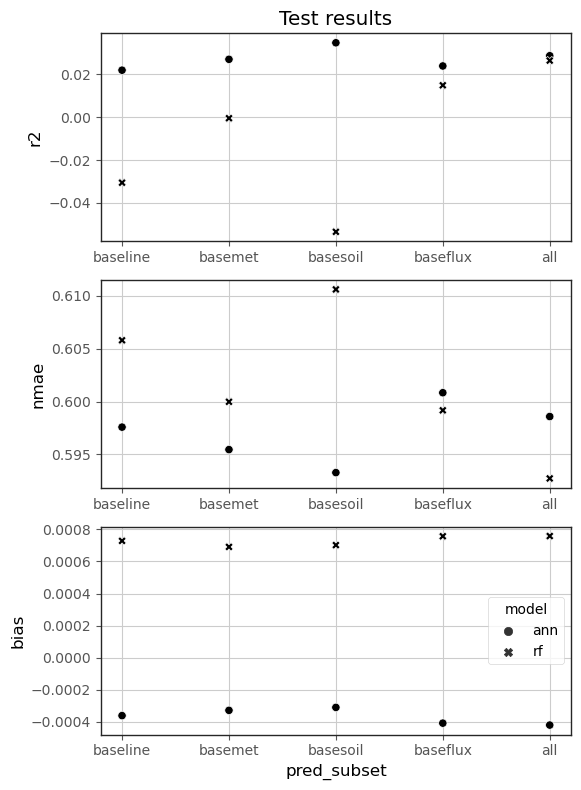

In [172]:
fig, ax = plt.subplots(3,1,figsize = (6, 8))
sns.scatterplot(x='pred_subset',y='r2',style='model', color = 'k', data = tests, ax = ax[0])
sns.scatterplot(x='pred_subset',y='nmae',style='model', color = 'k', data = tests, ax = ax[1])
sns.scatterplot(x='pred_subset',y='bias',style='model', color = 'k', data = tests, ax = ax[2])

ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[0].set(xlabel = None, title = 'Test results')
ax[1].set(xlabel = None)
plt.tight_layout()

# plt.savefig(f'./output/methane-gapfill_{datetime.now().strftime("%Y%m%d")}_tests.png', dpi=300)

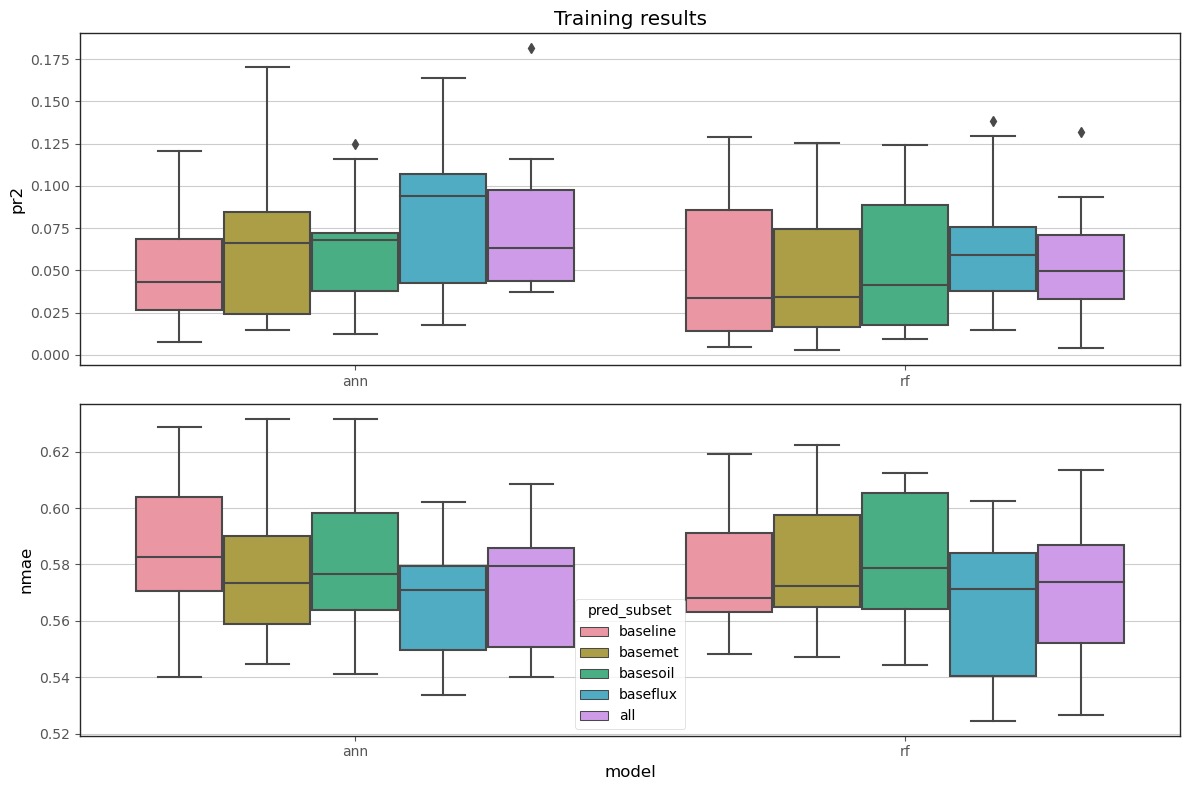

In [162]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
sns.boxplot(x='model', y='pr2', hue='pred_subset', data = training, ax = ax[0])
sns.boxplot(x='model', y='nmae', hue='pred_subset', data = training, ax = ax[1])

ax[0].get_legend().remove()
ax[0].set(xlabel = '', title = 'Training results')

plt.tight_layout()

# plt.savefig(f'./output/methane-gapfill_{datetime.now().strftime("%Y%m%d")}_training.png', dpi=300)

In [5]:
filepath = f'{data_dir}{project_dir}/models/ann/predictors/test_results.csv'
test_ann = pd.read_csv(filepath)

filepath = f'{data_dir}{project_dir}/models/rf/predictors/test_results.csv'
test_rf = pd.read_csv(filepath)

In [6]:
test_rf

,mse,mae,nmae,r2,pr2,bias,calibration,sharpness,normalized_sharpness,calibration_scaled,sharpness_scaled,normalized_sharpness_scaled,site,model,predictors_subset,predictors
0,0.000756,0.016411,0.605797,-0.030561,0.021226,0.000729,0.221729,0.007105,0.262262,0.937916,0.107216,3.957816,ATMOS_20230407_baseline,rf,predictors,DOY;sin_DOY;cos_DOY;air_temperature;SW_IN_POT;...


In [7]:
test_ann

,mse,mae,nmae,r2,pr2,bias,calibration,sharpness,normalized_sharpness,calibration_scaled,sharpness_scaled,normalized_sharpness_scaled,site,model,predictors_subset,predictors
0,0.000718,0.016188,0.597585,0.021887,0.025974,-0.000363,0.330377,0.010272,0.379171,0.926829,0.102516,3.78432,ATMOS_20230407_baseline,ann,predictors,DOY;sin_DOY;cos_DOY;air_temperature;SW_IN_POT;...


# Plot L3 fluxes

In [38]:
filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L3_2023-04-05.csv'

l3 = (pd.read_csv(filepath)
      .replace(-9999, np.nan)
      .assign(date = lambda x: pd.to_datetime(x['DATE']))
      .set_index('date')
      .sort_index())

filepath = '/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230405/gapfilled/rf_predictors_laplace.csv'

rf = (pd.read_csv(filepath)
      .replace(-9999, np.nan)
      .assign(date = lambda x: pd.to_datetime(x['DATE']))
      .set_index('date')
      .sort_index()
      .add_suffix('_RF')
     )

filepath = '/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230405/gapfilled/ann_predictors_laplace.csv'

ann = (pd.read_csv(filepath)
      .replace(-9999, np.nan)
      .assign(date = lambda x: pd.to_datetime(x['DATE']))
      .set_index('date')
      .sort_index()
      .add_suffix('_ANN')
     )

l3 = pd.concat([l3, rf.loc[:,'FCH4_F_RF':], ann.loc[:,'FCH4_F_ANN':]], axis=1)


# cols = ['FC', 'NEE_f', 'Reco', 'GPP_f', 'FCH4', 'FCH4_f', 'H_f'] # Fluxnet variables
cols = ['co2_flux', 'NEE_f', 'Reco', 'GPP_f', 'ch4_flux', 'FCH4_f', 'FCH4_F_RF', 'FCH4_F_ANN', 'H_f'] # Full output variables

dailysum = l3.loc[:, cols].groupby(pd.Grouper(freq='1D')).sum() * 1800 / 1000
dailysum.loc[:, 'LE_f'] = l3.loc[:, ['LE_f']].groupby(pd.Grouper(freq='1D')).sum()

/tmp/ipykernel_33814/2737010399.py:3: DtypeWarning: Columns (251,399) have mixed types. Specify dtype option on import or set low_memory=False.
  l3 = (pd.read_csv(filepath)
/tmp/ipykernel_33814/2737010399.py:11: DtypeWarning: Columns (249,397) have mixed types. Specify dtype option on import or set low_memory=False.
  rf = (pd.read_csv(filepath)
/tmp/ipykernel_33814/2737010399.py:21: DtypeWarning: Columns (249,397) have mixed types. Specify dtype option on import or set low_memory=False.
  ann = (pd.read_csv(filepath)


In [51]:
l3['FCH4', 'FCH4_f', 'FCH4_F_RF']

KeyError: ('FCH4', 'FCH4_f', 'FCH4_F_RF')

In [39]:
l3[l3.columns[l3.columns.str.contains('FCH4')]]

,FCH4_f,FCH4_fsd,FCH4_F_RF,FCH4_F_UNCERTAINTY_RF,FCH4_F1_RF,FCH4_F2_RF,FCH4_F3_RF,FCH4_F4_RF,FCH4_F5_RF,FCH4_F6_RF,...,FCH4_F1_ANN,FCH4_F2_ANN,FCH4_F3_ANN,FCH4_F4_ANN,FCH4_F5_ANN,FCH4_F6_ANN,FCH4_F7_ANN,FCH4_F8_ANN,FCH4_F9_ANN,FCH4_F10_ANN
date,,,,,,,,,,,,,,,,,,,,,
2022-05-24 10:30:00,-0.009860,0.000222,-0.009860,0.000000,-0.009860,-0.009860,-0.009860,-0.009860,-0.009860,-0.009860,...,-0.009860,-0.009860,-0.009860,-0.009860,-0.009860,-0.009860,-0.009860,-0.009860,-0.009860,-0.009860
2022-05-24 11:00:00,-0.035292,0.017761,-0.035292,0.000000,-0.035292,-0.035292,-0.035292,-0.035292,-0.035292,-0.035292,...,-0.035292,-0.035292,-0.035292,-0.035292,-0.035292,-0.035292,-0.035292,-0.035292,-0.035292,-0.035292
2022-05-24 11:30:00,-0.018363,0.063439,-0.020871,0.043213,-0.070268,0.013078,-0.009661,-0.033109,0.013395,-0.028211,...,0.047460,-0.109797,-0.060886,0.030324,0.025492,-0.036912,-0.014226,-0.020836,0.030330,0.030145
2022-05-24 12:00:00,-0.015347,0.064371,-0.022562,0.033559,-0.066084,-0.032267,0.001281,-0.023691,-0.005994,-0.016032,...,0.049623,-0.109881,-0.062709,0.031529,0.025878,-0.037544,-0.016918,-0.020436,0.031127,0.028383
2022-05-24 12:30:00,-0.107285,0.048737,-0.107285,0.000000,-0.107285,-0.107285,-0.107285,-0.107285,-0.107285,-0.107285,...,-0.107285,-0.107285,-0.107285,-0.107285,-0.107285,-0.107285,-0.107285,-0.107285,-0.107285,-0.107285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-14 08:30:00,-0.006475,0.008065,-0.000858,0.020108,-0.011521,0.021809,-0.011820,0.002190,0.002722,0.001620,...,-0.034612,-0.013496,0.021122,-0.014947,0.061001,-0.007326,-0.014417,-0.014365,0.007857,0.007713
2023-02-14 09:00:00,-0.001679,0.000533,-0.001679,0.000000,-0.001679,-0.001679,-0.001679,-0.001679,-0.001679,-0.001679,...,-0.001679,-0.001679,-0.001679,-0.001679,-0.001679,-0.001679,-0.001679,-0.001679,-0.001679,-0.001679
2023-02-14 09:30:00,-0.001289,0.004211,-0.001289,0.000000,-0.001289,-0.001289,-0.001289,-0.001289,-0.001289,-0.001289,...,-0.001289,-0.001289,-0.001289,-0.001289,-0.001289,-0.001289,-0.001289,-0.001289,-0.001289,-0.001289


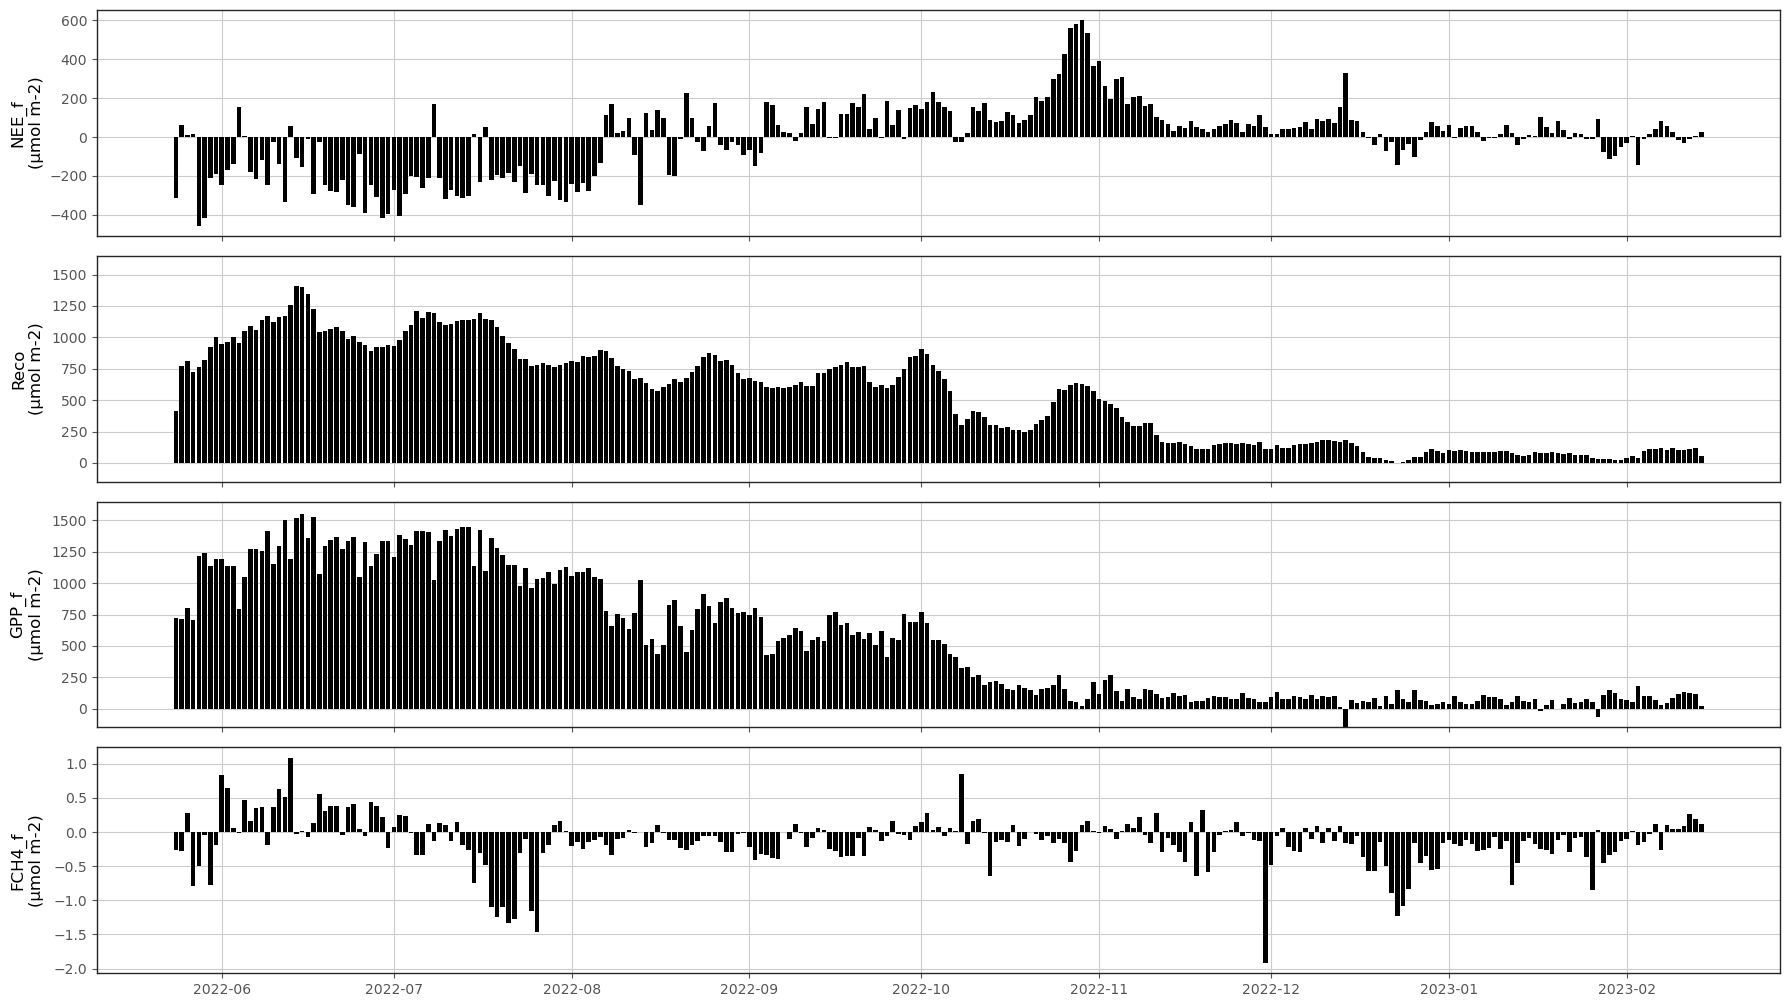

In [46]:
# cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']
cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

for i in range(len(cols)):
    ax[i].bar(dailysum.index, dailysum[cols[i]], color = 'k', linestyle = 'None')
    ax[i].set(ylabel = cols[i] + '\n(µmol m-2)')
    
ax[1].set(ylim = [-150,1650])
ax[2].set(ylim = [-150,1650])
plt.tight_layout()
fig.align_ylabels(ax[:])

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_gapfilled.png', dpi=300)


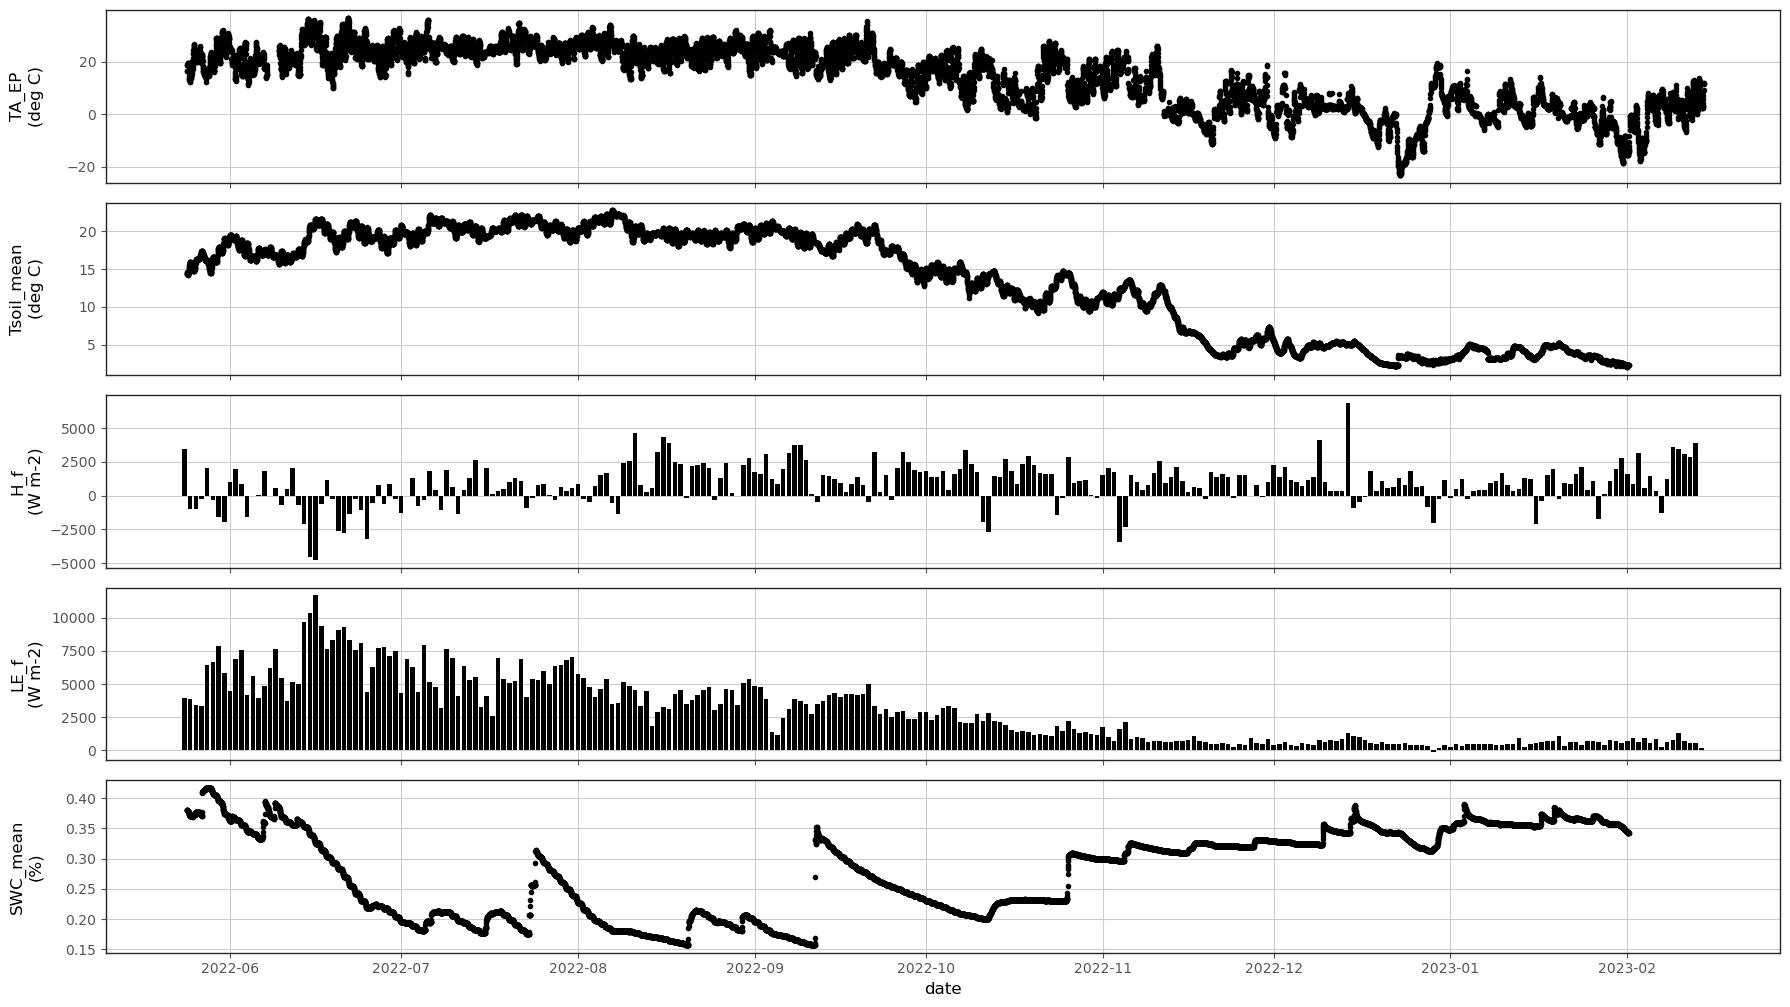

In [13]:
cols = ['TA_EP', 'Tsoil_mean', 'H_f', 'LE_f', 'SWC_mean']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

ax[0].plot(l3[cols[0]], color = 'k', linestyle='None')
ax[1].plot(l3[cols[1]], color = 'k', linestyle='None')
ax[2].bar(dailysum.index, dailysum[cols[2]], color = 'k', linestyle='None')
ax[3].bar(dailysum.index, dailysum[cols[3]], color = 'k', linestyle='None')
ax[4].plot(l3[cols[4]], color = 'k', linestyle='None')

ax[0].set(ylabel = cols[0] + '\n(deg C)')
ax[1].set(ylabel = cols[1] + '\n(deg C)')
ax[2].set(ylabel = cols[2] + '\n(W m-2)')
ax[3].set(ylabel = cols[3] + '\n(W m-2)')
ax[4].set(ylabel = cols[4] + '\n(%)', xlabel = 'date')

plt.tight_layout()
fig.align_ylabels(ax[:])
# plt.savefig(f'./output/atmos_L3met_{datetime.now().strftime("%Y%m%d")}.png', dpi=300)

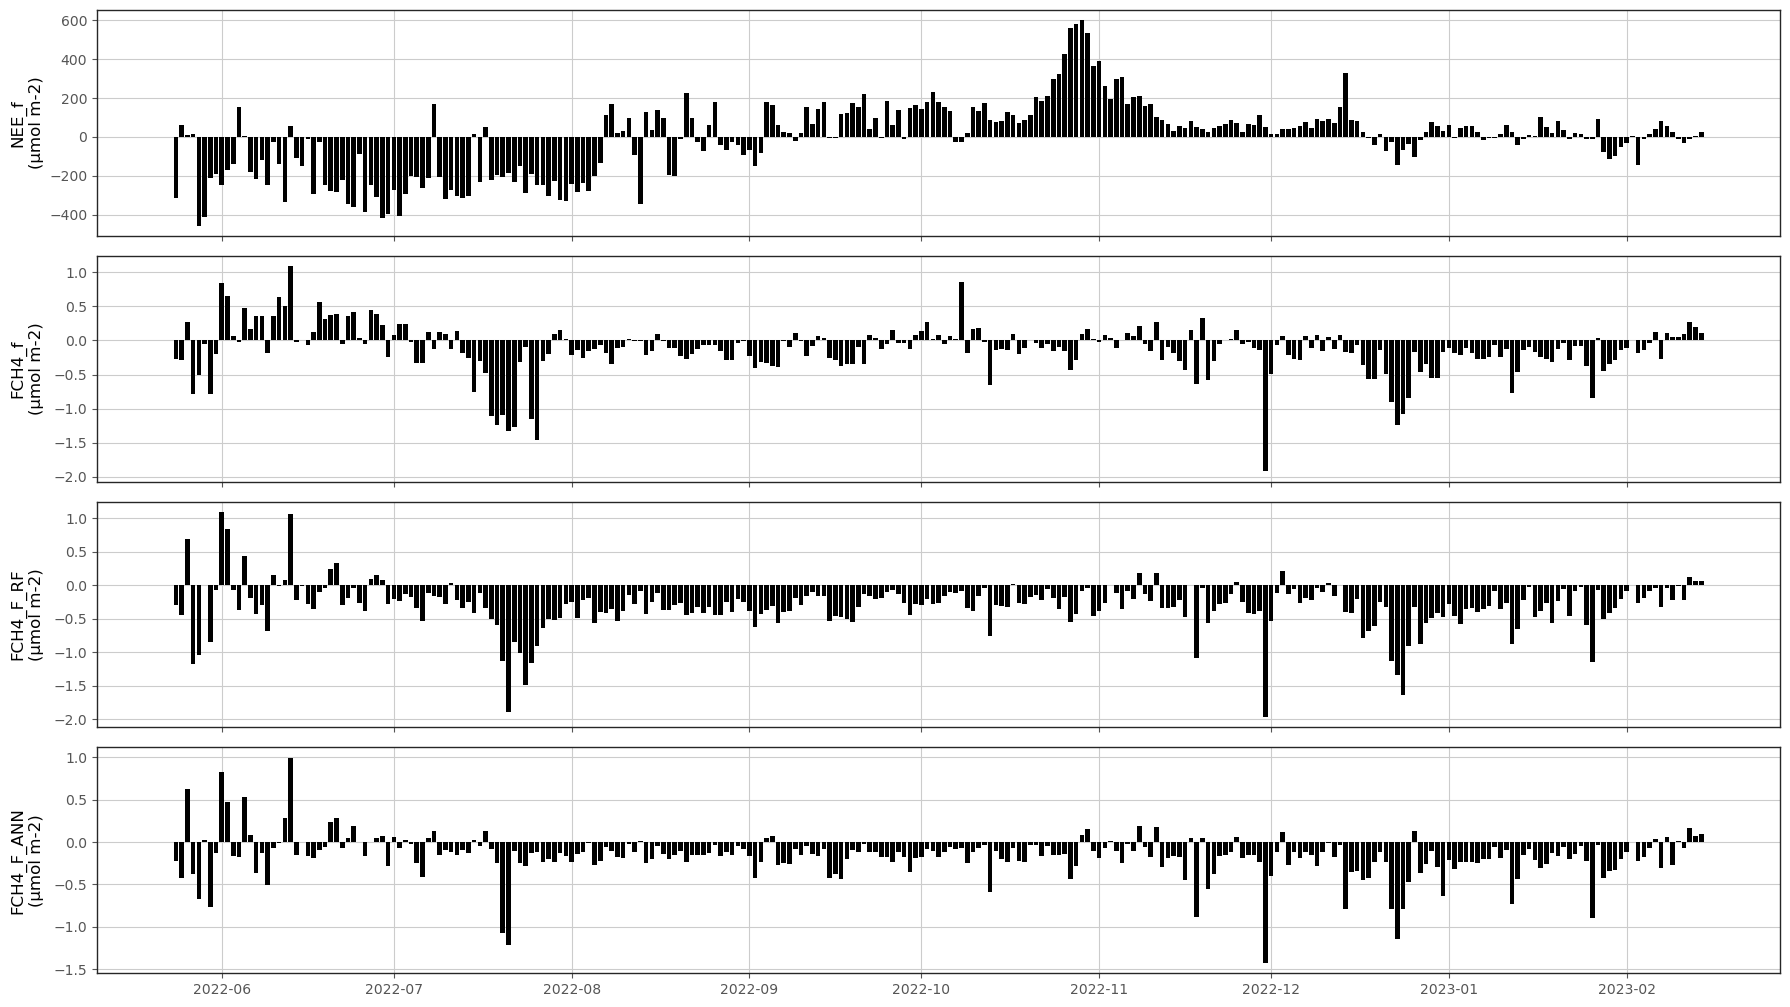

In [48]:
# cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']
cols = ['NEE_f', 'FCH4_f', 'FCH4_F_RF', 'FCH4_F_ANN']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

for i in range(len(cols)):
    ax[i].bar(dailysum.index, dailysum[cols[i]], color = 'k', linestyle = 'None')
    ax[i].set(ylabel = cols[i] + '\n(µmol m-2)')
    
plt.tight_layout()
fig.align_ylabels(ax[:])

plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_ch4models.png', dpi=300)


In [87]:
mask1 = l3.columns.str.contains('G_')
mask2 = l3.columns.str.contains('RATIO')
mask3 = l3.columns.str.contains('LAG')
mask4 = l3.columns.str.contains('WD')
l3[l3.columns[mask4]]

,WD_FILTER_NR,WD,WD_SIGMA,WD_FILTER_NREX,WD60,WD_STD60,WD10,WD_STD10
date,,,,,,,,
2022-05-24 13:30:00,18000.0,247.8900,38.4218,0.0,89.0,0.0,63.2,28.9
2022-05-24 14:00:00,18000.0,253.6240,31.8325,0.0,NaN,NaN,NaN,NaN
2022-05-24 14:30:00,18000.0,249.2380,30.6542,0.0,777.7,777.7,72.8,21.9
2022-05-24 15:00:00,18000.0,253.4170,29.3374,0.0,NaN,NaN,NaN,NaN
2022-05-24 15:30:00,18000.0,249.4370,34.7957,0.0,60.9,13.8,71.1,14.6
...,...,...,...,...,...,...,...,...
2022-11-30 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-30 22:30:00,18000.0,83.6459,16.4263,0.0,285.6,9.9,283.0,14.1
2022-11-30 23:00:00,18000.0,80.8154,16.0334,0.0,NaN,NaN,NaN,NaN


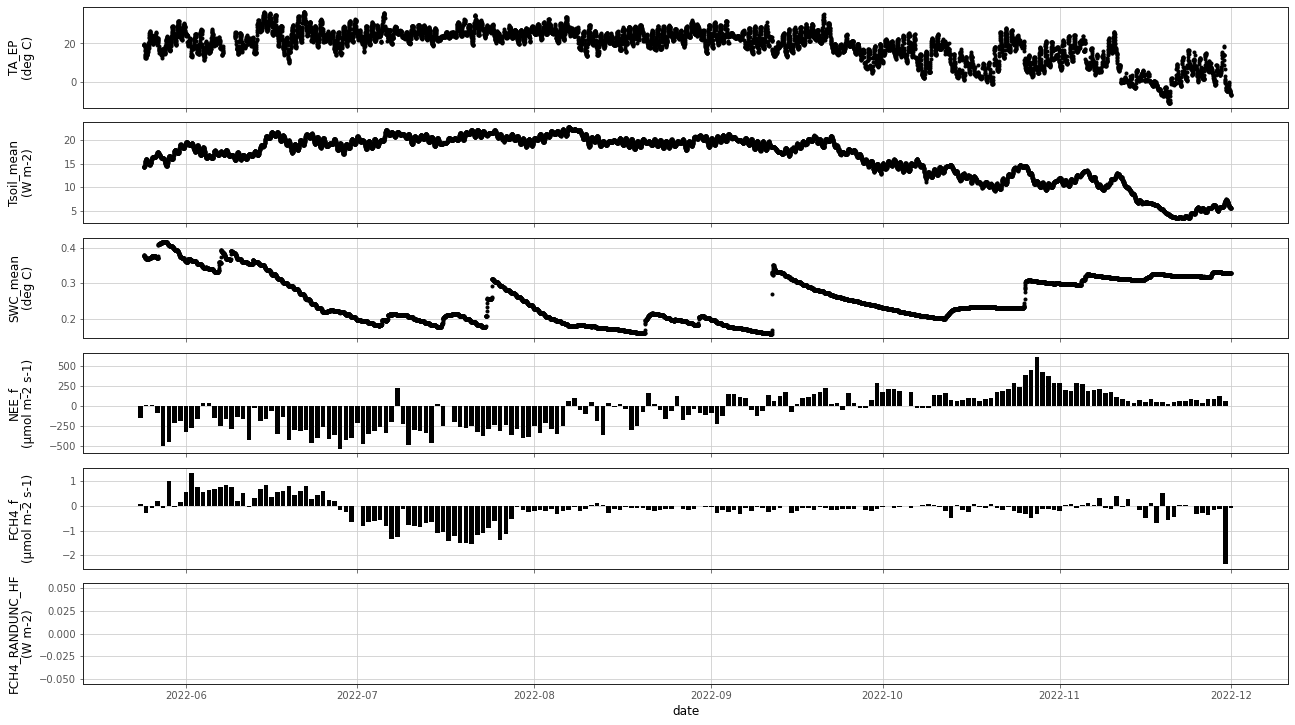

In [7]:
cols = ['TA_EP', 'Tsoil_mean', 'SWC_mean', 'NEE_f', 'FCH4_f', 'FCH4_RANDUNC_HF']

fig, ax = plt.subplots(6,1, figsize = (10*1.8, 5.65*1.8), sharex = True)
ax[0].plot(l3[cols[0]], color = 'k', linestyle='None')
ax[1].plot(l3[cols[1]], color = 'k', linestyle='None')
ax[2].plot(l3[cols[2]], color = 'k', linestyle='None')
ax[3].bar(dailysum.index, dailysum[cols[3]], color = 'k', linestyle='None')
ax[4].bar(dailysum.index, dailysum[cols[4]], color = 'k', linestyle='None')
ax[5].plot(l3[cols[5]], color = 'k', linestyle='None')

ax[0].set(ylabel = cols[0] + '\n(deg C)')
ax[1].set(ylabel = cols[1] + '\n(W m-2)')
ax[2].set(ylabel = cols[2] + '\n(deg C)')
ax[3].set(ylabel = cols[3] + '\n(µmol m-2 s-1)')
ax[4].set(ylabel = cols[4] + '\n(µmol m-2 s-1)')
ax[5].set(ylabel = cols[5] + '\n(W m-2)', xlabel = 'date')
plt.tight_layout()
fig.align_ylabels(ax[:])
# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d%H%M")}.png', dpi=300)

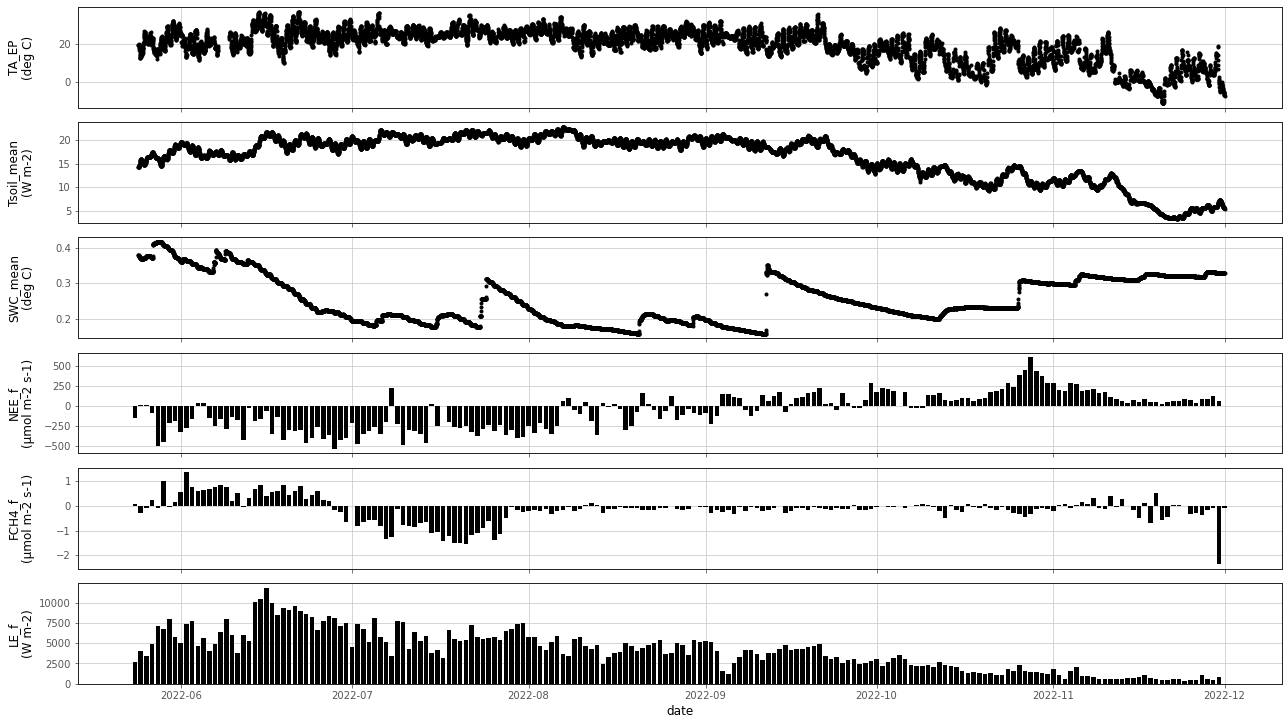

In [4]:
cols = ['TA_EP', 'Tsoil_mean', 'SWC_mean', 'NEE_f', 'FCH4_f', 'LE_f']

fig, ax = plt.subplots(6,1, figsize = (10*1.8, 5.65*1.8), sharex = True)
ax[0].plot(l3[cols[0]], color = 'k', linestyle='None')
ax[1].plot(l3[cols[1]], color = 'k', linestyle='None')
ax[2].plot(l3[cols[2]], color = 'k', linestyle='None')
ax[3].bar(dailysum.index, dailysum[cols[3]], color = 'k', linestyle='None')
ax[4].bar(dailysum.index, dailysum[cols[4]], color = 'k', linestyle='None')
ax[5].bar(dailysum.index, dailysum[cols[5]], color = 'k', linestyle='None')

ax[0].set(ylabel = cols[0] + '\n(deg C)')
ax[1].set(ylabel = cols[1] + '\n(W m-2)')
ax[2].set(ylabel = cols[2] + '\n(deg C)')
ax[3].set(ylabel = cols[3] + '\n(µmol m-2)')
ax[4].set(ylabel = cols[4] + '\n(µmol m-2)')
ax[5].set(ylabel = cols[5] + '\n(W m-2)', xlabel = 'date')
plt.tight_layout()
fig.align_ylabels(ax[:])
# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d%H%M")}.png', dpi=300)